In [1]:
# SIR Model Complex Network (Generating connections)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.animation 
import numpy as np
import networkx as nx
import copy
from itertools import product
from itertools import permutations
from statistics import mean
import warnings #This is just to suppress any error warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
from datetime import datetime

In [2]:
#For diff recovery times later
def gamma_distribution(mean_days):
    scale = 1 # set to 1 by default. Can change later
    result = int(np.round(np.random.gamma(mean_days)))
    if result == 0: #means if no.of days to recovery is less than 1, we set it to be at least 1
        result = 1
    return result

### <u> 4. Stochastic Model (Simplicial Complex) </u>

#### <u> 4.1 Simplicial Complex </u>

A simplicial complex, denoted by $\Phi$, is a topological space constructed by combining lower dimensional simplices, $\phi$ (vertex - 0 simplice, line - 1 simplice, triangles - 2 simplice, tetrahedrons - 3 simplice, etc). Formally, $\Phi$ on a given set of vertices $V$, is a collection of simplices, with the extra requirement that if simplex $\sigma$ is an element of $\Phi$, then all the subsimplices $ν$ ⊂ $\sigma$ built from subsets of $\sigma$ are also contained in $\Phi$.

Simplicial complexes are built on complex social networks by identifying possible 1-simplices (edges), 2-simplices (triangles) and more, in an ascending order, thus considering all forms of interactions from bottom up. This represents an epidemic in a more realistic manner. In our model, we shall adopt the idea of simplicial complexes, up to 2-simplex, on our previously constructed ER, WS and BA networks, and observe the dynamics of the previously defined reproduction numbers. 

#### <u> 4.2 2-Simplex construction </u>
In each network, there will be cases where three vertex (individuals) connect to form a triangle (2-simplice). By iterating all possible edges of the nodes, we can identify the total number of triangles in the network. In our construction, each triangle will automatically be a 2-simplex. The number of 2-simplex in each network is shown below <br><br>
Similar to finding the $<k>$ for the pairwise case, we should also find the average degree of connectivity, $<k_{sc}>$, for the 2-simplex case in order to know the average number of group interactions each individual has. To do so, we take:

$<k_{sc}>$ = (3 * #no.of 2-simplex) / N <br> 

The numerator has a multiplication of 3 to account for each 2-simplex interaction experienced by each individual in a triangle, and the denominator is N to find the average. 


In [3]:
# Networks used in Chapter 3
seed = 2367181
np.random.seed(seed)
N = 500

# (1) Random network
ER_network = nx.erdos_renyi_graph(N, p = 10/499, seed = seed) #(1) p = probability of connecting 2 nodes
ER_edges = list(ER_network.edges())
ER_average_deg = (len(ER_network.edges) * 2)/N #Average degree of ER network
# print(ER_average_deg)
# ER_title = "Erdo-Renyi with Average Degree: " + str(ER_average_deg)
# plt.figure(figsize = (18,15))
# position_ER = nx.spring_layout(ER_network, scale = 8)
# plt.figure(1)
# plt.title(ER_title)
# nx.draw(ER_network, position_ER, with_labels = True, font_size = 8, font_weight = 'bold', node_color = '#66ff33')


# (2) Small world network: k = no. of neighbours != odd , p = probability of rewiring 
WS_network = nx.connected_watts_strogatz_graph(N, k = 10, p = 0.5, seed = seed) 
WS_edges = list(WS_network.edges())
WS_average_deg = (len(WS_network.edges) * 2)/N #Average degree of WS network
# print(WS_average_deg)

# WS_title = "Watts Strogatz with Average Degree: " + str(WS_average_deg)
# plt.figure(figsize = (40,16))
# position_WS = nx.spring_layout(WS_network, scale = 50)
# plt.figure(2)
# plt.title(WS_title)
# nx.draw(WS_network, position_WS, with_labels = True, font_size = 8, font_weight = 'bold', node_color = '#66ff33')
# plt.show()

# (3) Scale free network: m = no.of edges to attach from new to existing node
BA_network = nx.barabasi_albert_graph(N, m = 5, seed = seed) 
BA_edges = list(BA_network.edges())
BA_average_deg = (len(BA_network.edges) * 2)/N #Average degree of BA network
# print(BA_average_deg)

# BA_title = "Barabasi Albert with Average Degree: " + str(BA_average_deg)
# plt.figure(figsize = (18,15))
# position_BA = nx.spring_layout(BA_network, scale = 8)
# plt.figure(3)
# plt.title(BA_title)
# nx.draw(BA_network, position_BA, with_labels = True, font_size = 8, font_weight = 'bold', node_color = '#66ff33')

plt.show()
# Each network has an approximate average degree of 10 

In [4]:
#Identifying the number of possible 2 simplices in each network
def simplices_2_hunter(graph_edges): #2-simplices    
    edges_unzip = [[i for i, j in graph_edges], [j for i, j in graph_edges]]
    row1 = np.array(edges_unzip[0])
    row2 = np.array(edges_unzip[1])

    triangle_list = []
    for k in range(len(graph_edges)):
        u = graph_edges[k][0]
        v = graph_edges[k][1]
        index1 = np.where(row1 == v)[0] 
        index2 = np.where(row2 == v)[0]    
    
        if len(index1) != 0:
            for i in index1:
                index_1 = np.where(row2 == row2[i])[0]
                for j in index_1:
                    if row1[j] == u:
                        triangle_list.append([u, v, row2[j]])

        if len(index2) != 0:
            for i in index2:
                index_2 = np.where(row1 == row1[i])[0]
                for j in index_2:
                    if row2[j] == u:
                        triangle_list.append([u, v, row1[j]])

    for l in range (len(triangle_list)):
        triangle_list[l].sort()
        
    triangle_graph = np.unique([tuple(row) for row in np.array(triangle_list)], axis = 0)
    return triangle_graph 

In [5]:
#EXTRA HELPER FUNCTION FOR PLOTTING PURPOSES ON COMPLEX NETWORK TRANSITION DIAGRAM. Nothing special!
def simplices_edges(simplices_edges, graph_edges): 
    # simplices edges would be the arrays of triangles after user has chose from simplices_2_hunter 
    # graph edges are the supposed graph edges from the network (list w tuple)
    all_edges = []
    for i in simplices_edges:
        pairings = permutations(i, 2) #2 here is to choose the pair of links
        for j in list(pairings):
            all_edges.append(j)
    
    return list(set(all_edges) & set(graph_edges)) 
    #function returns an intersection so that we know the edges to "shade" on our network

In [6]:
simplex2_ER = simplices_2_hunter(ER_edges)
simplex2_WS = simplices_2_hunter(WS_edges)
simplex2_BA = simplices_2_hunter(BA_edges)
print(len(simplex2_ER), len(simplex2_WS), len(simplex2_BA))
print("Simplex2 degree of ER network is:", (len(simplex2_ER)*3)/N)
print("Simplex2 degree of WS network is:", (len(simplex2_WS)*3)/N)
print("Simplex2 degree of BA network is:", (len(simplex2_BA)*3)/N)

192 710 655
Simplex2 degree of ER network is: 1.152
Simplex2 degree of WS network is: 4.26
Simplex2 degree of BA network is: 3.93


#### <u> 4.3 Group infectibility $r_{sc}$ </u>
Analogous to the pairwise infectibility $r_l$, which characterizes viral transmission in the pairwise case, we should also devise a method to represent viral transmissions in a group setting. To do so, we begin by formalizing how a group transmission occurs in the 2-simplex. <br>

A 2-simplex transmission will happens under two conditions:
1. A susceptible individual is in a 2-simplex with two other infected individuals. 
2. The pairwise transmission between each S-I edge in the 2-simplex has failed.

Both conditions are necessary in order to fulfil the idea of bottom up interactions. 

With the formalism completed, we now introduce the group infectibility $r_{sc}$. $r_{sc}$ is an input parameter and is defined as the product of the probability of virus transmissions in a 2-simplex, $p_{sc}$ and the average degree of 2-simplex in each network $<k_{sc}>$. Like $r_l$, it is used as a standardizing variable to ensure that all networks have the same reproducibility in regard to group interactions. <br>

As <$k_{sc}$> for the ER network is small, we can only consider $r_{sc}$: {0.5, 0.75, 1} for all networks in subsequent sections. Though this implies a smaller $p_{sc}$ for both WS and BA networks, it is compensated by a larger <$k_{sc}$> in these networks.

#### <u> 4.4 Modified simulation methodology </u>
The simulation works exactly the same way as before except with the 'Additional Check'. The idea of the check is to know if 2-simplex actually takes place. If it did, we will modify the "transmission vector" so that the actual $r_T$ now registers a larger value. <br>

With the modification, we find the canonical average as before

In [10]:
#Simulation for ONE RUN!
def simulation_2_simplex(I0, days_to_recover, r_l, network, simulation_seeds, gamma_recovery, activate_2_simp, chosen_2_simp, r_triangle): 
    # Parameters:
    # I_0, days_to_recover, r_l, network, simulation_seeds (self explanatory as per stochastic model)
    # simulation_seeds is a list but for one simulation is a list w one element
    # gamma_recovery = 0 or 1. (0 means fixed D_recover. 1 means follows gamma distribution). By default is 0
    gamma_distribution_activate = gamma_recovery
    
    # activate_2_simp: if 1 means run 2-simplex code. 0 means no
    # chosen_2_simp: the triangles chosen from the network
    # r_triangle: to find the probability of triangle transmission. Analogous to using r_l
    
    ######## This is to set the probability of transmission in pairwise interactions #############
    probability_infection_pair = r_l / ((len(network.edges) * 2) / (network.number_of_nodes()))
    
    ######## This is to set the probability of transmission for 2-simplex interactions #############
    probability_infection_simplex = r_triangle / ((len(chosen_2_simp) * 3) / (network.number_of_nodes()))
    
    # 7 important lists for all plots
    susceptible_progression_matrix = []
    infection_progression_matrix = []
    recovered_progression_matrix = []
    R_t_version1_matrix = []
    R_t_version2_matrix = []
    R_t_version3_matrix = []
    network_changes_matrix = []

    for i in simulation_seeds:
        seed_network = i
        np.random.seed(i)
        index = np.sort(np.random.choice(N, I0, replace = False))

        #Versions of R_t
        R_t_version1 = [] #just raw changes in infected numbers
        R_t_version2 = [] #as long as someone is infected, will treat as he got from all neighbours even if its not true
        R_t_version3 = [] #god's view. We will know who are the exact transmitters

        #Simulation code
        infected_vector = np.zeros(N) #tracks infection
        recovery_vector = np.zeros(N) #tracks recovery

        infected_vector[index] = 1
        recovery_vector[index] = days_to_recover
        previous_infected_vector = np.copy(infected_vector) #To register the previous day's infected vector for comparison
        previous_recovery_vector = np.copy(recovery_vector) #To register the previous day's recovery vector for comparison

        network_changes = np.copy(infected_vector) #To get changes in the number of infectious individuals daily, master copy

        while len(index) != 0: #assuming recovery time is D day and that we only stop when no one gets infected 
            connection = list(network.edges(index)) 
#             print(connection)
            actual_transmission = []

            for i in range(len(connection)):
                transmit_virus = np.random.choice(2, 1, p = [1 - probability_infection_pair, probability_infection_pair]) 
                actual_transmission.append(transmit_virus[0])

                if transmit_virus == 1:
                    if infected_vector[connection[i][1]] >= 1 :
                        continue
                    else:                  
                        infected_vector[connection[i][1]] += 1
                        if gamma_distribution_activate == 0:
                            recovery_vector[connection[i][1]] += days_to_recover
                        #In our case we ignore gamma_activate since we wont be doing this
                        elif gamma_distribution_activate == 1:
                            gamma_recovery_days = gamma_distribution(days_to_recover)
                            recovery_vector[connection[i][1]] += gamma_recovery_days
                            
            actual_transmission_simplicial = actual_transmission.copy()               
                            
            if activate_2_simp == 1: # !!!!!!! ADDITIONAL CHECK !!!!!!!!!!!!!
                for h in chosen_2_simp:
                    index_of_infected_individuals = np.array(list(set(h) & set((np.where(previous_infected_vector == 1))[0]))).astype(int)

                    if len(index_of_infected_individuals) == 0 or len(index_of_infected_individuals) == 1: 
                        # Comment: means no two individuals in the 2-simplex has been infected. 
                        continue

                    elif len(index_of_infected_individuals) == 2:
                        # Comment: If len(index_of_infected_individuals) == 2, it means that i have found the two vertices v1, v2. 
                        # Now i just have to check the index of (v1, v3) and (v2, v3) in the "connection" list and check its 
                        # actual_transmission index.
                        v1, v2 = index_of_infected_individuals[0], index_of_infected_individuals[1]
                        v3 = np.array(list(set(h) ^ set((index_of_infected_individuals)))).astype(int)[0]
                        v1v3, v2v3 = connection.index((v1, v3)), connection.index((v2, v3)) #Found the index corresponding to actual_transmission_simplicial

                        # Comment: To check if v3 in the 2-simplex (v1, v2, v3) has been infected
                        check_infected_state = int(infected_vector[v3]) 

                        #If check_infected_state is 0, means the pairwise interaction is unsuccessful in making it infected!
                        #We therefore have to invoke the simplicial complex transmission

                        if check_infected_state == 0:
                            simplice_transmit = np.random.choice(2, 1, p = [1 - probability_infection_simplex, probability_infection_simplex])[0]
                            # Comment: Add 2 counts to R_T if transmission is yes
                            if simplice_transmit == 1:
                                infected_vector[v3] += 1
                                recovery_vector[v3] += days_to_recover
                                actual_transmission_simplicial[v1v3], actual_transmission_simplicial[v2v3] = 1, 1

                        #If check_infected_state is 1, means the pairwise interaction is successful in making it infected!
                        #But we do not know as of yet who are the ones that infect it. 

                        elif check_infected_state == 1:
                            simplice_transmit = np.random.choice(2, 1, p = [1 - probability_infection_simplex, probability_infection_simplex])[0] #Gives either 1 or 0
                            # Comment: Now i find all infected connections linking to node check_infected_index
                            if simplice_transmit == 1:
                                actual_transmission_simplicial[v1v3], actual_transmission_simplicial[v2v3] = 1, 1
            
            for j in index: #this is to update the recovery_vector
                if previous_recovery_vector[j] == 1: 
                    recovery_vector[j] -= 1
                    infected_vector[j] = 3 #once its equals to 3, it means the person will not get infected anymore

                elif previous_recovery_vector[j] > 1:
                    recovery_vector[j] -= 1

            #Number of previously infected individuals:
            number_of_previous_infected = len((np.where(previous_infected_vector == 1))[0])
            
            #Finding R_t_version1
            index_of_new_infections = np.where((infected_vector - previous_infected_vector) == 1)[0]
            daily_new_infections = (len(index_of_new_infections))/number_of_previous_infected
            R_t_version1.append(daily_new_infections)

            #Finding R_t_version2
            overestimate_count = 0
            for k in connection:
                if k[1] in index_of_new_infections:
                    if previous_infected_vector[k[0]] == 1:
                        overestimate_count += 1
            R_t_version2.append(overestimate_count/number_of_previous_infected)

            #Finding R_t_version3
            transmission_counter = 0
            if activate_2_simp == 0:
                for l in list(connection):
                    if l[1] in index_of_new_infections:
                        if actual_transmission[(list(connection).index(l))] == 1:
                            transmission_counter +=1
                R_t_version3.append(transmission_counter/number_of_previous_infected)


            elif activate_2_simp == 1:
                for l in list(connection):
                    if l[1] in index_of_new_infections:
                        if actual_transmission_simplicial[(list(connection).index(l))] == 1:
                            transmission_counter +=1
                R_t_version3.append(transmission_counter/number_of_previous_infected)

            #For updating vectors
            previous_infected_vector = np.copy(infected_vector)
            previous_recovery_vector = np.copy(recovery_vector)
            network_changes = np.vstack([network_changes, infected_vector])
            index = np.where(infected_vector == 1)[0]
            
        susceptible_progression = np.count_nonzero(network_changes.astype(int) == 0, axis=1)
        susceptible_progression_matrix.append(list(susceptible_progression))
        infection_progression = np.count_nonzero(network_changes.astype(int) == 1, axis=1)
        infection_progression_matrix.append(list(infection_progression))
        recovered_progression = np.count_nonzero(network_changes.astype(int) == 3, axis=1)
        recovered_progression_matrix.append(list(recovered_progression))

        R_t_version1_matrix.append(R_t_version1)
        R_t_version2_matrix.append(R_t_version2)
        R_t_version3_matrix.append(R_t_version3)
        network_changes_matrix.append(network_changes)
        
    return susceptible_progression_matrix, infection_progression_matrix, recovered_progression_matrix, \
            R_t_version1_matrix, R_t_version2_matrix, R_t_version3_matrix, network_changes_matrix

#returns S, I, R, under, over, true reproduction numbers, and the changes in the network

In [11]:
#Standard Deviation Finder
def standard_deviation(data_set, mean):
    #Check if they are in np array since this works with numpy
    if type(data_set) != np.ndarray:
        data_set = np.array(data_set)
        
    if type(mean) != np.ndarray:
        mean = np.array(mean)
    
    variance = np.sum((data_set - mean.transpose())**2, axis = 0)/len(data_set)
    sd = (variance**0.5)
    return sd

In [12]:
def simulation_average(N_runs, number_of_simulations):
    extrapolated_susceptible = N_runs[0].copy()
    extrapolated_infection = N_runs[1].copy()
    extrapolated_recovered = N_runs[2].copy()
    
    extrapolated_R_t_version1 = N_runs[3].copy()
    extrapolated_R_t_version2 = N_runs[4].copy()
    extrapolated_R_t_version3 = N_runs[5].copy()
    
    max_time = len(max((extrapolated_infection), key = len)) #the max length is the same for susceptible & recovered
    
    for i in range(number_of_simulations):
        if len(extrapolated_susceptible[i]) < max_time:
            add_last_susceptible = [extrapolated_susceptible[i][-1]]*(max_time - len(extrapolated_susceptible[i]))
            extrapolated_susceptible[i] = extrapolated_susceptible[i] + add_last_susceptible

            add_last_infected = [extrapolated_infection[i][-1]]*(max_time - len(extrapolated_infection[i]))
            extrapolated_infection[i] = extrapolated_infection[i] + add_last_infected

            add_last_recovered = [extrapolated_recovered[i][-1]]*(max_time - len(extrapolated_recovered[i]))
            extrapolated_recovered[i] = extrapolated_recovered[i] + add_last_recovered
            
    max_time_R_t = len(max((extrapolated_R_t_version1), key = len)) #the max length is the same for all types of R_t
    
    for i in range(number_of_simulations):
        if len(extrapolated_R_t_version1[i]) < max_time_R_t:
            add_last_R_t_version1 = [extrapolated_R_t_version1[i][-1]]*(max_time_R_t - len(extrapolated_R_t_version1[i]))
            extrapolated_R_t_version1[i] = extrapolated_R_t_version1[i] + add_last_R_t_version1

            add_last_R_t_version2 = [extrapolated_R_t_version2[i][-1]]*(max_time_R_t - len(extrapolated_R_t_version2[i]))
            extrapolated_R_t_version2[i] = extrapolated_R_t_version2[i] + add_last_R_t_version2

            add_last_R_t_version3 = [extrapolated_R_t_version3[i][-1]]*(max_time_R_t - len(extrapolated_R_t_version3[i]))
            extrapolated_R_t_version3[i] = extrapolated_R_t_version3[i] + add_last_R_t_version3
                   
                
    #Finding the mean of the SIR data
    average_susceptible = np.array(extrapolated_susceptible).mean(axis = 0)
    average_infected = np.array(extrapolated_infection).mean(axis = 0)
    average_recovered = np.array(extrapolated_recovered).mean(axis = 0)
    max_time_scale = np.arange(1, max_time+1, step = 1)
    
    #Finding the Standard Deviation of the SIR data
    susceptible_SD = standard_deviation(extrapolated_susceptible, average_susceptible)
    infected_SD = standard_deviation(extrapolated_infection, average_infected)
    recovered_SD = standard_deviation(extrapolated_recovered, average_recovered)
    
    #Finding the mean of the Reproduction Numbers 
    average_R_t_version1 = np.array(extrapolated_R_t_version1).mean(axis = 0)
    average_R_t_version2 = np.array(extrapolated_R_t_version2).mean(axis = 0)
    average_R_t_version3 = np.array(extrapolated_R_t_version3).mean(axis = 0)
    max_time_scale_R_t = np.arange(1, max_time_R_t+1, step = 1)
    
    #Finding the Standard Deviation of the Reproduction Numbers data    
    R_t_V1_SD = standard_deviation(extrapolated_R_t_version1, average_R_t_version1)
    R_t_V2_SD = standard_deviation(extrapolated_R_t_version2, average_R_t_version2)
    R_t_V3_SD = standard_deviation(extrapolated_R_t_version3, average_R_t_version3)
           
    return [max_time_scale, average_susceptible, average_infected, average_recovered, susceptible_SD, infected_SD,\
           recovered_SD], [max_time_scale_R_t, average_R_t_version1, average_R_t_version2, average_R_t_version3, \
                           R_t_V1_SD, R_t_V2_SD, R_t_V3_SD], average_R_t_version1[0]

#simulation_average[0] - a list containing all data related to SIR 
#simulation_average[0][0] - SIR time scale
#simulation_average[0][1], [0][2], [0][3] - S, I & R mean 
#simulation_average[0][4], [0][5], [0][6] - S, I & R SD

#simulation_average[1] - a list containing all data related to Reproduction Numbers
#simulation_average[1][0] - Reproduction Number time scale
#simulation_average[1][1], [1][2], [1][3] - r_U, r_O, r_t mean 
#simulation_average[1][4], [1][5], [1][6] - r_U, r_O, r_t SD

#simulation_average[2] - the ensemble $r_l$

#### <u> 4.5 Effects of different $r_{sc}$ on networks</u>
With the addition of 2-simplex on our complex social networks, we seek to evaluate any differences in the reproduction numbers for different $r_l$ and $D_{recover}$.

#### <u> 4.5.1 Effects of $r_{sc}$ for different $r_l$</u>
In this section, we compare the effects of different $r_{sc}$ for inputs $r_l$ = 3 & 9. Inputs $D_{recover}$ and $I_0$ are set to 3 and 1 repectively. The results are shown below:

In [10]:
#Executing the simulations for N-Runs
np.random.seed(43434)
number_of_simulations = 10
N_simulation_seeds = np.random.choice(100000, number_of_simulations, replace = False)

I0 = 1
D_recover = 3
r_l = 3

################### Simplicial complex stuff below ###########
activate_2_simplex = 1 #either 0 or 1
r_triangle_set = [0.5, 0.75, 1] 

In [ ]:
ER_average_simulation_result_r_l = []
ER_average_ensemble_local_r_l = []

WS_average_simulation_result_r_l = []
WS_average_ensemble_local_r_l = []

BA_average_simulation_result_r_l = []
BA_average_ensemble_local_r_l = []

for a in r_triangle_set
    ER_N_runs_r_l = simulation_2_simplex(I0, D_recover, r, ER_network, N_simulation_seeds,0)[0:-1]
    ER_N_runs_average_r_l = simulation_average(ER_N_runs_r_l, number_of_simulations)[1:3]
    ER_average_ensemble_local_r_l.append(ER_N_runs_ensemble_local)

for b in WS_r_l:
    WS_N_runs_r_l = simulation(I0, D_recover, b, WS_network, N_simulation_seeds,0)[0:-1]
    WS_N_runs_average_r_l = simulation_average(WS_N_runs_r_l, number_of_simulations)[1:3]
    WS_N_runs_ensemble_local = 1 - ((abs(b - WS_N_runs_average_r_l[-1])) / b)
    WS_average_simulation_result_r_l.append(WS_N_runs_average_r_l[0])
    WS_average_ensemble_local_r_l.append(WS_N_runs_ensemble_local)
    
for c in BA_r_l:
    BA_N_runs_r_l = simulation(I0, D_recover, c, BA_network, N_simulation_seeds,0)[0:-1]
    BA_N_runs_average_r_l = simulation_average(BA_N_runs_r_l, number_of_simulations)[1:3]
    BA_N_runs_ensemble_local = 1 - ((abs(c - BA_N_runs_average_r_l[-1])) / c)
    BA_average_simulation_result_r_l.append(BA_N_runs_average_r_l[0])
    BA_average_ensemble_local_r_l.append(BA_N_runs_ensemble_local)

In [14]:
# #Executing the simulations for N-Runs
# np.random.seed(43434)
# number_of_simulations = 5000
# N_simulation_seeds = np.random.choice(100000, number_of_simulations, replace = False)

# I0 = 1
# D_recover = 3
# r_l = 9

# ################### Simplicial complex stuff below ###########
# activate_2_simplex = 1 #either 0 or 1
# r_triangle_set = [0.5, 0.75, 1] 

In [15]:
#For rl = 9

location_1b = r"C:\Users\lione\Desktop\Y4S2\PH4421 FYP\Data for simplicial complex\Part (1) Comparing rl = 3 & 9 for SC = 0.5, 0.75,1 for D = 3 [Show failure of SC]\rl=9 test diff r_tri D = 3"
ER_1b_data = [] #index 0: no simplex, 1: 0.5, and so on
WS_1b_data = []
BA_1b_data = []

file_names_ER_1b = ["\ER_avr_simplex_rl9_r_tri_none", "\ER_avr_simplex_rl9_r_tri_0.5", \
                "\ER_avr_simplex_rl9_r_tri_0.75", "\ER_avr_simplex_rl9_r_tri_1"]

file_names_WS_1b = ["\WS_avr_simplex_rl9_r_tri_none", "\WS_avr_simplex_rl9_r_tri_0.5", \
                "\WS_avr_simplex_rl9_r_tri_0.75", "\WS_avr_simplex_rl9_r_tri_1"]

file_names_BA_1b = ["\BA_avr_simplex_rl9_r_tri_none", "\BA_avr_simplex_rl9_r_tri_0.5", \
                "\BA_avr_simplex_rl9_r_tri_0.75", "\BA_avr_simplex_rl9_r_tri_1"]

for j in range(4):
    ER_1b_data.append(csv_file_opener(location_1b, file_names_ER_1b[j]))
    WS_1b_data.append(csv_file_opener(location_1b, file_names_WS_1b[j]))
    BA_1b_data.append(csv_file_opener(location_1b, file_names_BA_1b[j]))

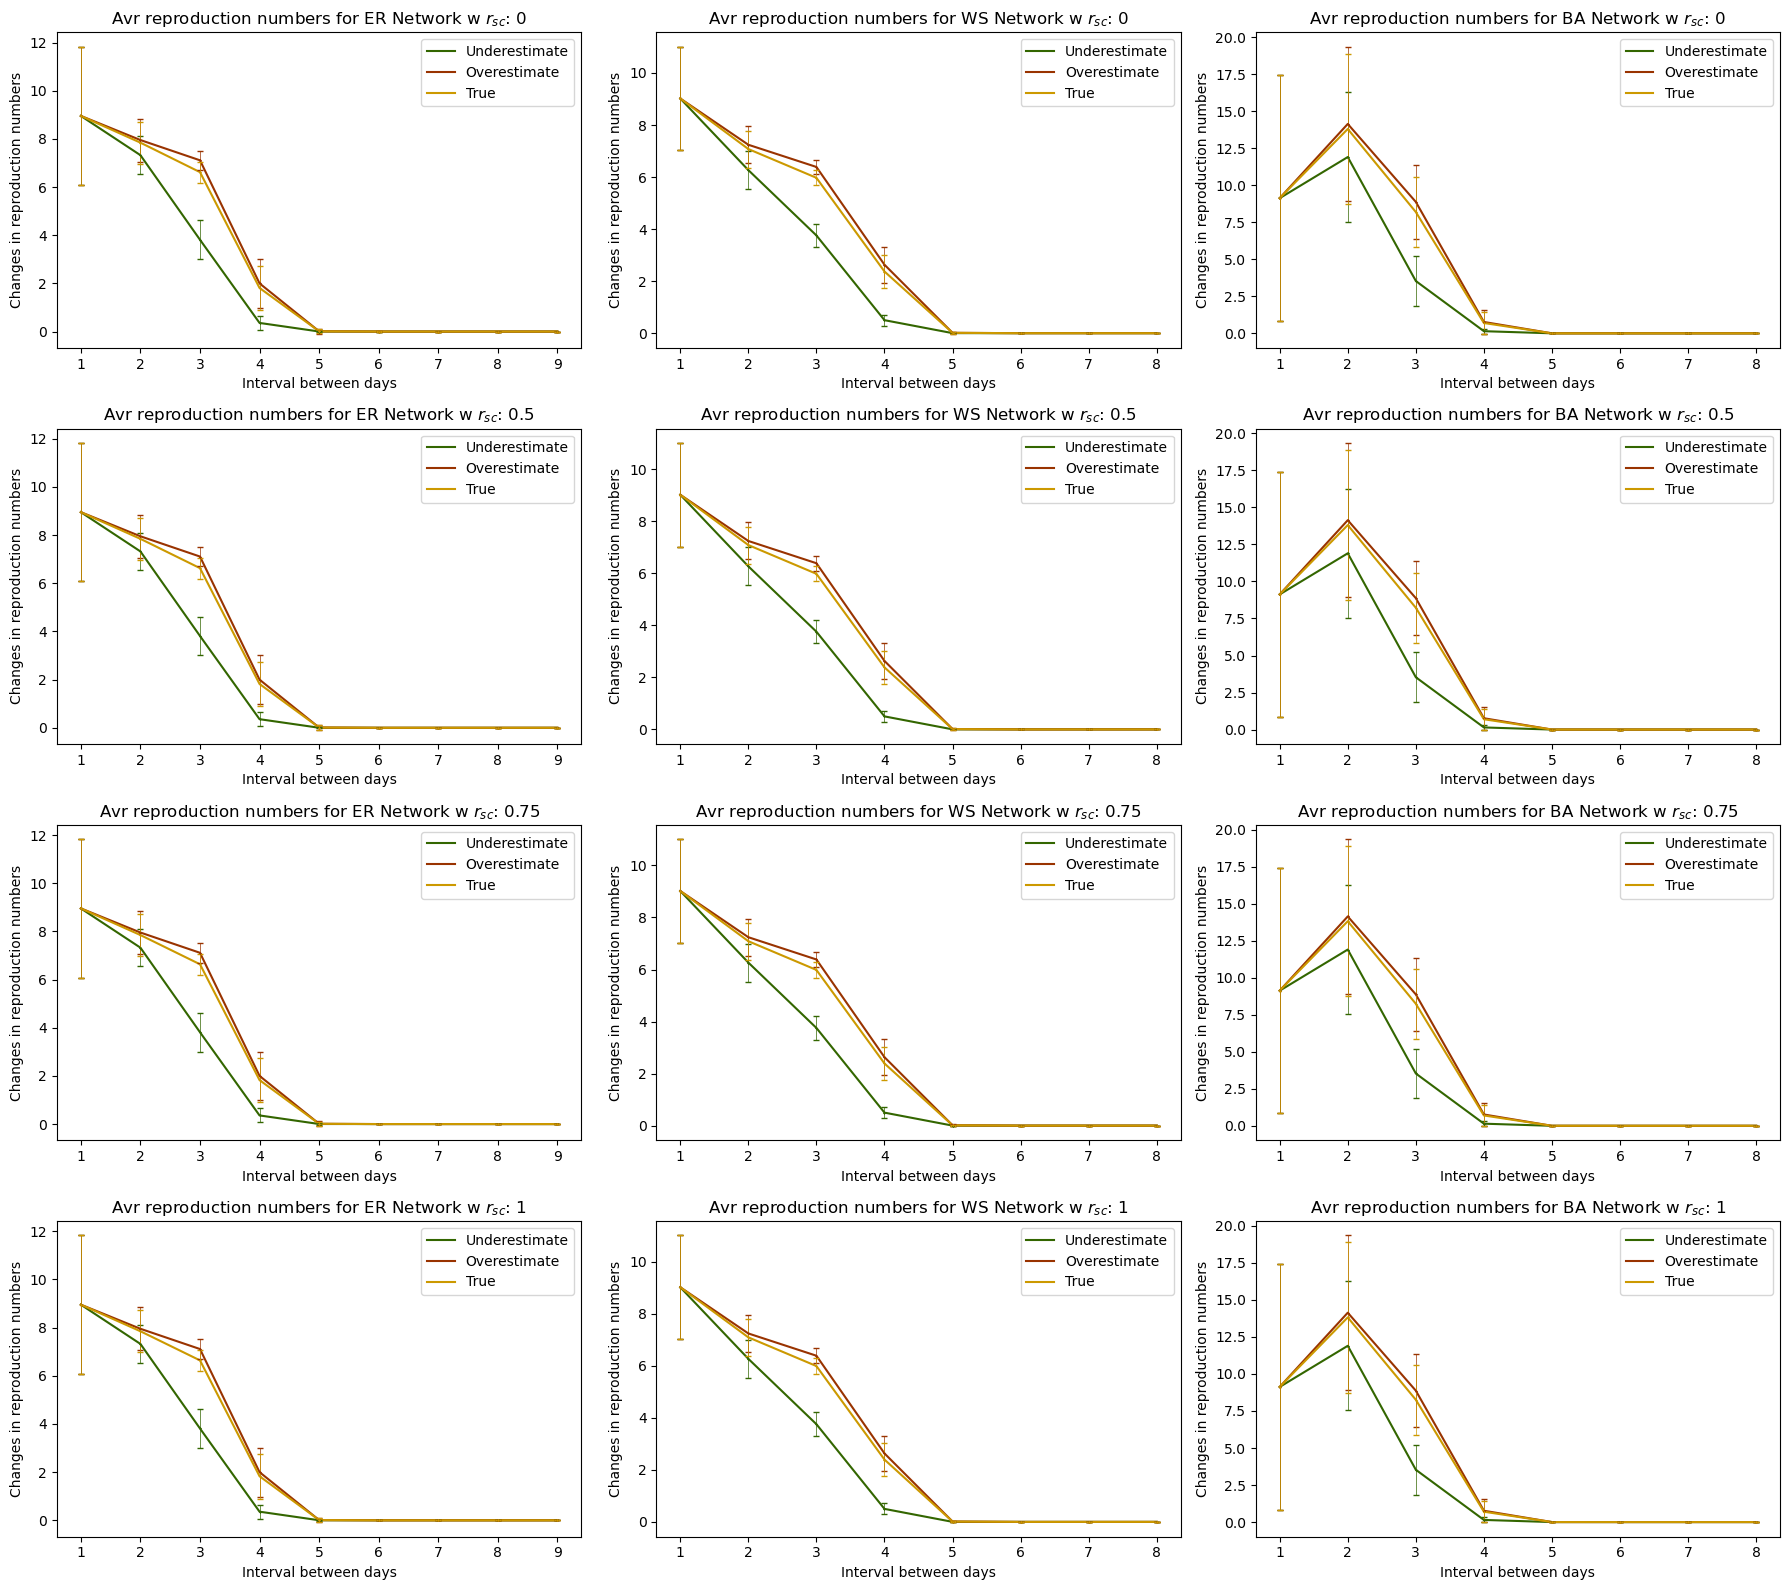

In [16]:
fig, axs = plt.subplots(4, 3, figsize = (18,16))

for k in range(4):
    ######### For ER Network #########
    axs[k][0].plot(ER_1b_data[k][0], ER_1b_data[k][1], label  = "Underestimate", color = '#336600')
    axs[k][0].plot(ER_1b_data[k][0], ER_1b_data[k][2], label  = "Overestimate", color = '#993300')
    axs[k][0].plot(ER_1b_data[k][0], ER_1b_data[k][3], label  = "True", color = '#cc9900')
    
    axs[k][0].errorbar(ER_1b_data[k][0], ER_1b_data[k][1], yerr = ER_1b_data[k][4],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#336600')
    axs[k][0].errorbar(ER_1b_data[k][0], ER_1b_data[k][2], yerr = ER_1b_data[k][5],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#993300')
    axs[k][0].errorbar(ER_1b_data[k][0], ER_1b_data[k][3], yerr = ER_1b_data[k][6],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#cc9900')
    
    axs[k][0].set_xticks(np.arange(1, len(ER_1b_data[k][0])+1, 1))
    
    ER_title_label= "Avr reproduction numbers for ER Network w $r_{sc}$: " + str(r_triangle_set[k])    
    axs[k][0].set_title(ER_title_label)
    axs[k][0].set_xlabel("Interval between days")
    axs[k][0].set_ylabel("Changes in reproduction numbers")
    axs[k][0].legend(loc = 1)
    
    ######### For WS Network #########
    axs[k][1].plot(WS_1b_data[k][0], WS_1b_data[k][1], label  = "Underestimate", color = '#336600')
    axs[k][1].plot(WS_1b_data[k][0], WS_1b_data[k][2], label  = "Overestimate", color = '#993300')
    axs[k][1].plot(WS_1b_data[k][0], WS_1b_data[k][3], label  = "True", color = '#cc9900')

    axs[k][1].errorbar(WS_1b_data[k][0], WS_1b_data[k][1], yerr = WS_1b_data[k][4],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#336600')
    axs[k][1].errorbar(WS_1b_data[k][0], WS_1b_data[k][2], yerr = WS_1b_data[k][5],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#993300')
    axs[k][1].errorbar(WS_1b_data[k][0], WS_1b_data[k][3], yerr = WS_1b_data[k][6],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#cc9900')
    
    axs[k][1].set_xticks(np.arange(1, len(WS_1b_data[k][0])+1, 1))
    
    WS_title_label= "Avr reproduction numbers for WS Network w $r_{sc}$: " + str(r_triangle_set[k])    
    axs[k][1].set_title(WS_title_label)
    axs[k][1].set_xlabel("Interval between days")
    axs[k][1].set_ylabel("Changes in reproduction numbers")
    axs[k][1].legend(loc = 1)
    
    ######### For BA Network #########
    axs[k][2].plot(BA_1b_data[k][0], BA_1b_data[k][1], label  = "Underestimate", color = '#336600')
    axs[k][2].plot(BA_1b_data[k][0], BA_1b_data[k][2], label  = "Overestimate", color = '#993300')
    axs[k][2].plot(BA_1b_data[k][0], BA_1b_data[k][3], label  = "True", color = '#cc9900')

    axs[k][2].errorbar(BA_1b_data[k][0], BA_1b_data[k][1], yerr = BA_1b_data[k][4],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#336600')
    axs[k][2].errorbar(BA_1b_data[k][0], BA_1b_data[k][2], yerr = BA_1b_data[k][5],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#993300')
    axs[k][2].errorbar(BA_1b_data[k][0], BA_1b_data[k][3], yerr = BA_1b_data[k][6],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#cc9900')
    
    axs[k][2].set_xticks(np.arange(1, len(BA_1b_data[k][0])+1, 1))
    
    BA_title_label= "Avr reproduction numbers for BA Network w $r_{sc}$: " + str(r_triangle_set[k])    
    axs[k][2].set_title(BA_title_label)
    axs[k][2].set_xlabel("Interval between days")
    axs[k][2].set_ylabel("Changes in reproduction numbers")
    axs[k][2].legend(loc = 1)
    
plt.tight_layout()
plt.show()

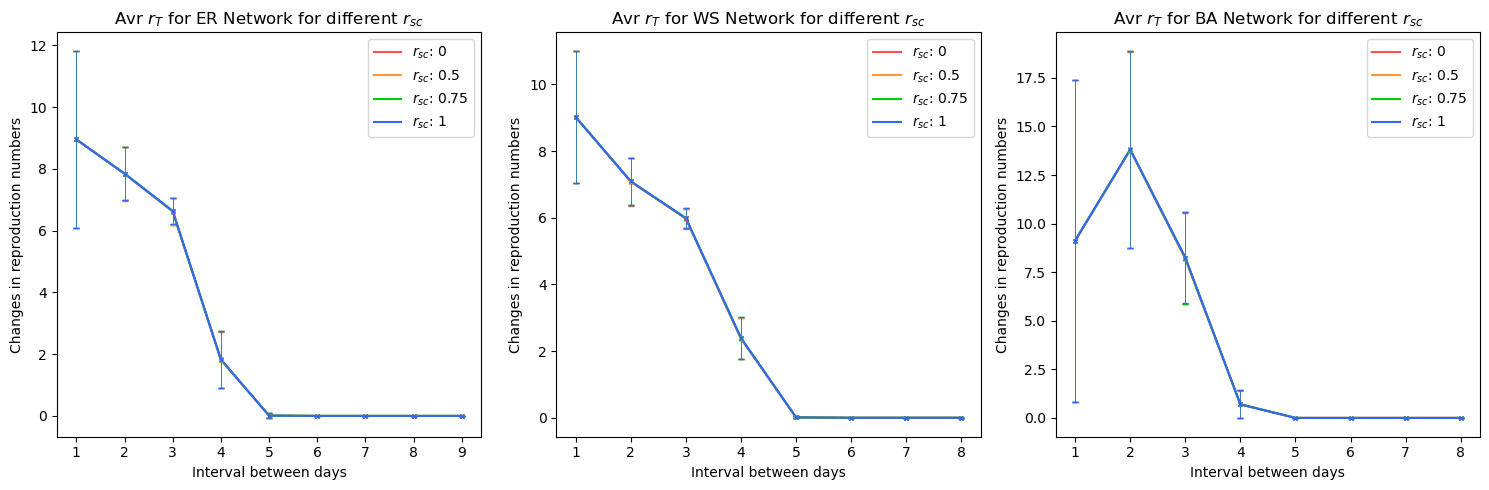

In [17]:
# 1b. Plot only r_T for each network and compare between networks
fig, axs = plt.subplots(1, 3, figsize = (15,5))
plot_colors = ['#ff5050', '#ff9933', '#00cc00', '#3366ff'] 
T_end_ER = max(len(ER_1b_data[0][0]), len(ER_1b_data[1][0]), len(ER_1b_data[2][0]), len(ER_1b_data[3][0]))
T_end_WS = max(len(WS_1b_data[0][0]), len(WS_1b_data[1][0]), len(WS_1b_data[2][0]), len(WS_1b_data[3][0]))
T_end_BA = max(len(BA_1b_data[0][0]), len(BA_1b_data[1][0]), len(BA_1b_data[2][0]), len(BA_1b_data[3][0]))

for k in range(4):
    plot_label = "$r_{sc}$: "+ str(r_triangle_set[k]) 
    ######### For ER Network #########
    axs[0].plot(ER_1b_data[k][0], ER_1b_data[k][3], label  = plot_label, color = plot_colors[k])
    axs[0].errorbar(ER_1b_data[k][0], ER_1b_data[k][3], yerr = ER_1b_data[k][6],\
                   fmt = 'x', markersize = 3, elinewidth = 0.5, capsize = 2, color = plot_colors[k]) 
    
    axs[0].set_xticks(np.arange(1, T_end_ER + 1, 1))
    
    ER_title_label= "Avr $r_T$ for ER Network for different $r_{sc}$"   
    axs[0].set_title(ER_title_label)
    axs[0].set_xlabel("Interval between days")
    axs[0].set_ylabel("Changes in reproduction numbers")
    axs[0].legend(loc = 1)
    
    ######### For WS Network #########
    axs[1].plot(WS_1b_data[k][0], WS_1b_data[k][3], label  = plot_label, color = plot_colors[k])
    axs[1].errorbar(WS_1b_data[k][0], WS_1b_data[k][3], yerr = WS_1b_data[k][6],\
                   fmt = 'x', markersize = 3, elinewidth = 0.5, capsize = 2, color = plot_colors[k])   
    axs[1].set_xticks(np.arange(1, T_end_WS + 1, 1))
    
    WS_title_label= "Avr $r_T$ for WS Network for different $r_{sc}$"   
    axs[1].set_title(WS_title_label)
    axs[1].set_xlabel("Interval between days")
    axs[1].set_ylabel("Changes in reproduction numbers")
    axs[1].legend(loc = 1)
    
    ######### For BA Network #########
    axs[2].plot(BA_1b_data[k][0], BA_1b_data[k][3], label  = plot_label, color = plot_colors[k])
    axs[2].errorbar(BA_1b_data[k][0], BA_1b_data[k][3], yerr = BA_1b_data[k][6],\
                   fmt = 'x', markersize = 3, elinewidth = 0.5, capsize = 2, color = plot_colors[k])   
    axs[2].set_xticks(np.arange(1, T_end_BA + 1, 1))
    
    BA_title_label= "Avr $r_T$ for BA Network for different $r_{sc}$"   
    axs[2].set_title(BA_title_label)
    axs[2].set_xlabel("Interval between days")
    axs[2].set_ylabel("Changes in reproduction numbers")
    axs[2].legend(loc = 1)
    
plt.tight_layout()
plt.show()

#### <u> 4.5.2 Using smaller $r_l$ </u>
As argued earlier, the effect of SC is very minimal and pairwise interactions seem to be the main cause of infection rather than group interactions. We try to understand why by scoping into the probability of transmission for each group interaction for the $r_{sc}$ set. [Insert table 2 to show probability]

Even for $r_l$ = 3, the pairwise interaction has a larger probability between each S-I edge (~ 0.3) that group for most cases. We now check what will happen if we do a small $r_l$ = 1 (~ pairwise infectious probability is 0.1 < group). In this scenario, what it could mean physically is that pairwise transmission between someone sick is not as "lethal" as those of groups, which is intuitively possible if we think about it. We test it out.

In [18]:
#For rl = 1
location_2b = r"C:\Users\lione\Desktop\Y4S2\PH4421 FYP\Data for simplicial complex\Part (2) Comparing rl = 1 & 2 for SC = 0.5, 0.75, 1 for D = 3 [Show success of SC]\TO USE rl = 1 test diff r_tri D = 3"
ER_2b_data = [] #index 0: no simplex, 1: 0.5, and so on
WS_2b_data = []
BA_2b_data = []

file_names_ER_2b = ["\ER_avr_simplex_rl1_r_tri_none", "\ER_avr_simplex_rl1_r_tri_0.5", \
                "\ER_avr_simplex_rl1_r_tri_0.75", "\ER_avr_simplex_rl1_r_tri_1"]

file_names_WS_2b = ["\WS_avr_simplex_rl1_r_tri_none", "\WS_avr_simplex_rl1_r_tri_0.5", \
                "\WS_avr_simplex_rl1_r_tri_0.75", "\WS_avr_simplex_rl1_r_tri_1"]

file_names_BA_2b = ["\BA_avr_simplex_rl1_r_tri_none", "\BA_avr_simplex_rl1_r_tri_0.5", \
                "\BA_avr_simplex_rl1_r_tri_0.75", "\BA_avr_simplex_rl1_r_tri_1"]

for j in range(4):
    ER_2b_data.append(csv_file_opener(location_2b, file_names_ER_2b[j]))
    WS_2b_data.append(csv_file_opener(location_2b, file_names_WS_2b[j]))
    BA_2b_data.append(csv_file_opener(location_2b, file_names_BA_2b[j]))

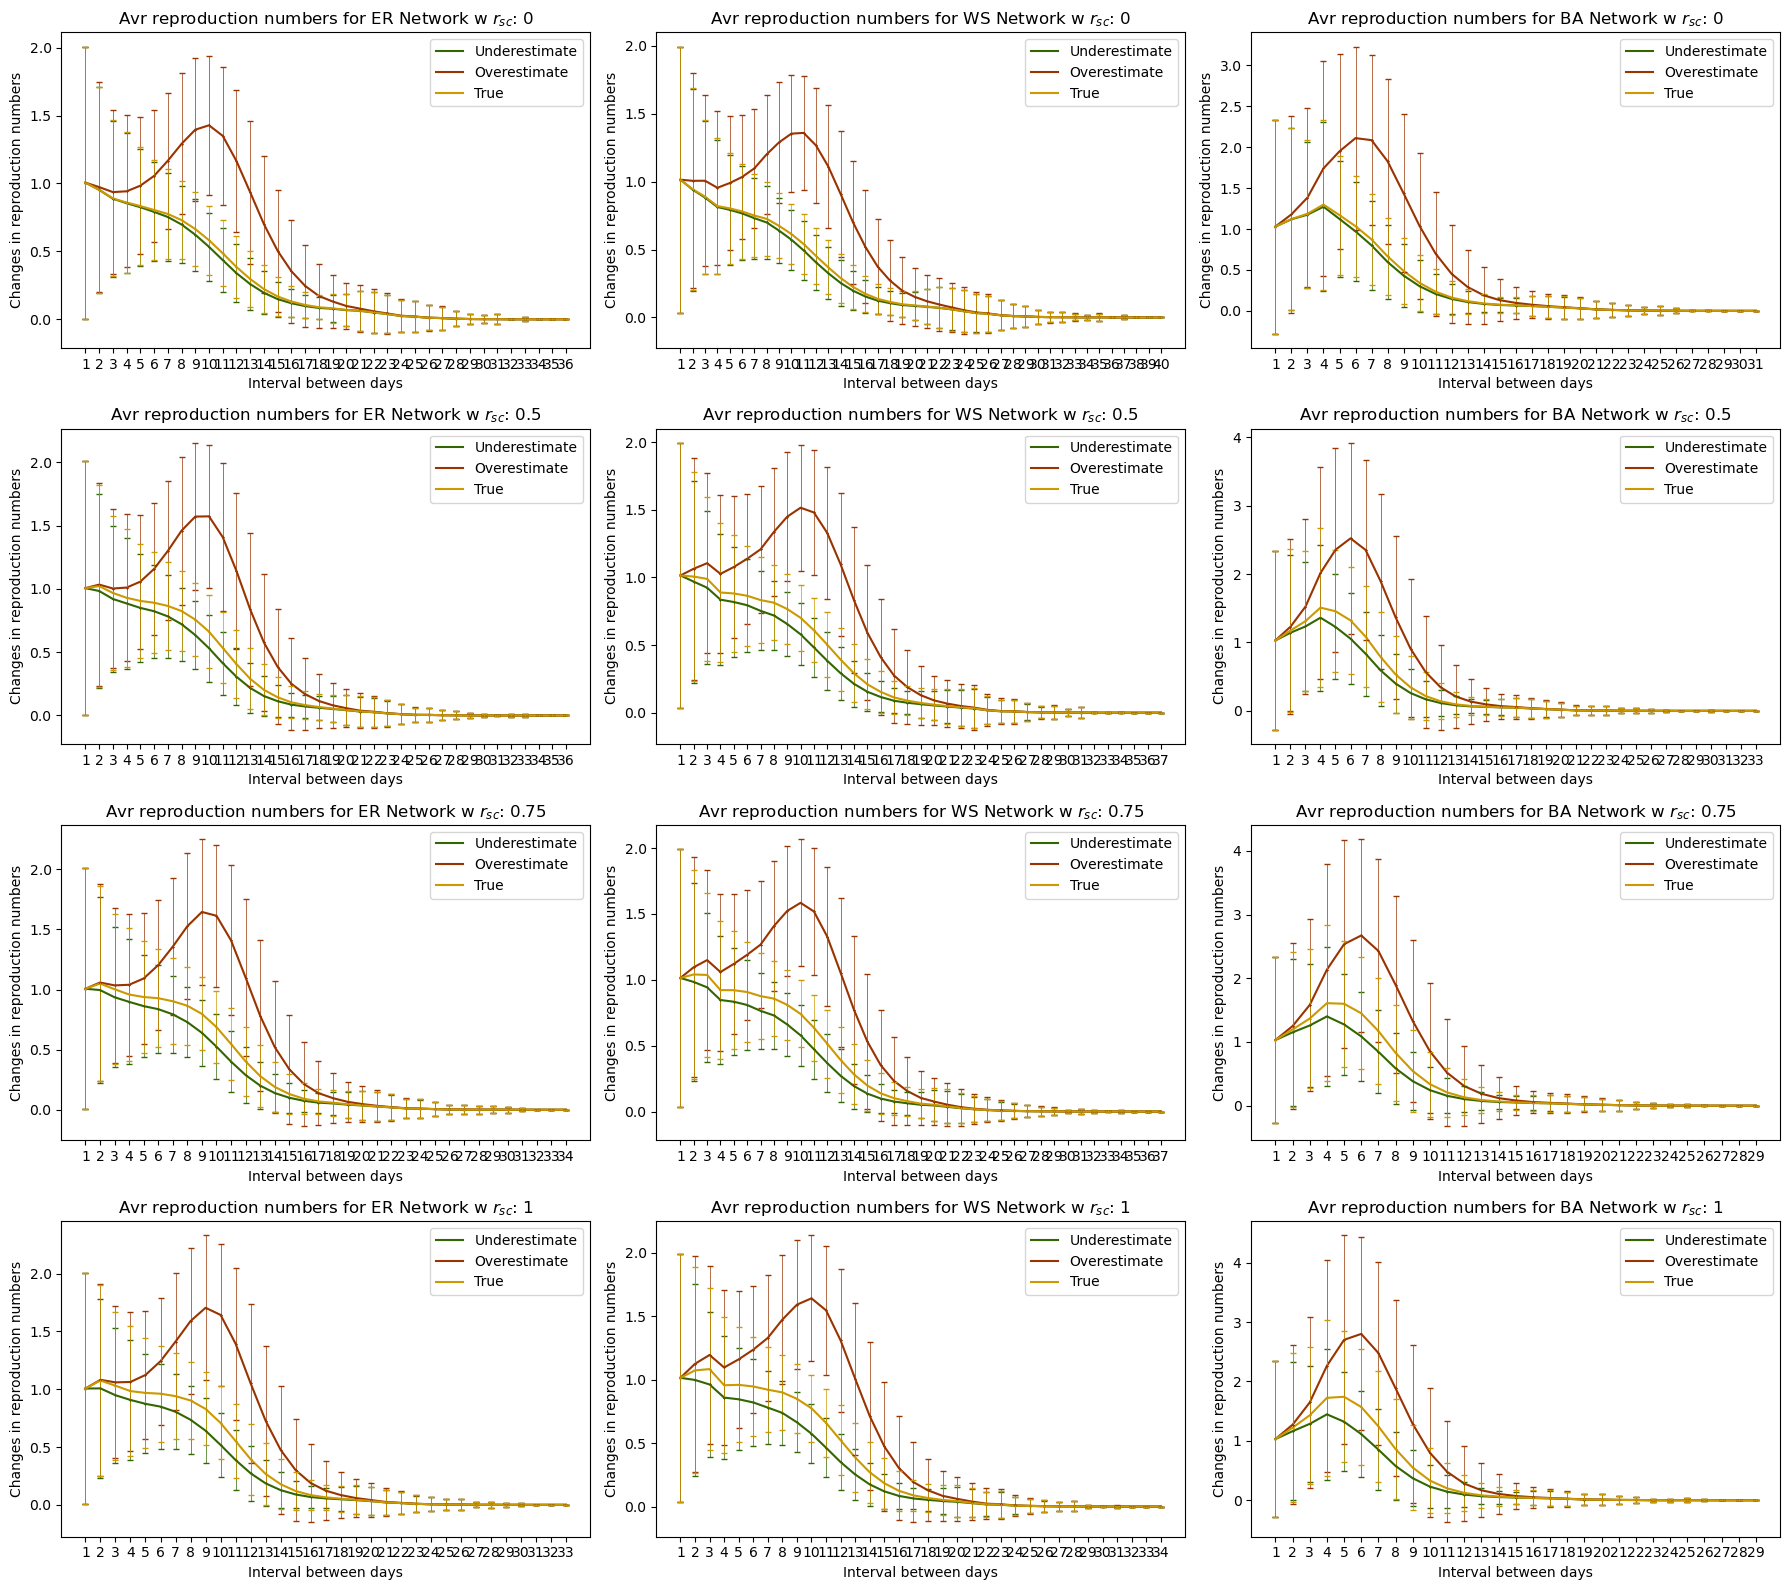

In [19]:
# 2b. Plot individual graphs with diff r triangle. 

fig, axs = plt.subplots(4, 3, figsize = (18,16))

for k in range(4):
    ######### For ER Network #########
    axs[k][0].plot(ER_2b_data[k][0], ER_2b_data[k][1], label  = "Underestimate", color = '#336600')
    axs[k][0].plot(ER_2b_data[k][0], ER_2b_data[k][2], label  = "Overestimate", color = '#993300')
    axs[k][0].plot(ER_2b_data[k][0], ER_2b_data[k][3], label  = "True", color = '#cc9900')
    
    axs[k][0].errorbar(ER_2b_data[k][0], ER_2b_data[k][1], yerr = ER_2b_data[k][4],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#336600')
    axs[k][0].errorbar(ER_2b_data[k][0], ER_2b_data[k][2], yerr = ER_2b_data[k][5],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#993300')
    axs[k][0].errorbar(ER_2b_data[k][0], ER_2b_data[k][3], yerr = ER_2b_data[k][6],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#cc9900')
    
    axs[k][0].set_xticks(np.arange(1, len(ER_2b_data[k][0])+1, 1))
    
    ER_title_label= "Avr reproduction numbers for ER Network w $r_{sc}$: " + str(r_triangle_set[k])    
    axs[k][0].set_title(ER_title_label)
    axs[k][0].set_xlabel("Interval between days")
    axs[k][0].set_ylabel("Changes in reproduction numbers")
    axs[k][0].legend(loc = 1)
    
    ######### For WS Network #########
    axs[k][1].plot(WS_2b_data[k][0], WS_2b_data[k][1], label  = "Underestimate", color = '#336600')
    axs[k][1].plot(WS_2b_data[k][0], WS_2b_data[k][2], label  = "Overestimate", color = '#993300')
    axs[k][1].plot(WS_2b_data[k][0], WS_2b_data[k][3], label  = "True", color = '#cc9900')

    axs[k][1].errorbar(WS_2b_data[k][0], WS_2b_data[k][1], yerr = WS_2b_data[k][4],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#336600')
    axs[k][1].errorbar(WS_2b_data[k][0], WS_2b_data[k][2], yerr = WS_2b_data[k][5],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#993300')
    axs[k][1].errorbar(WS_2b_data[k][0], WS_2b_data[k][3], yerr = WS_2b_data[k][6],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#cc9900')
    
    axs[k][1].set_xticks(np.arange(1, len(WS_2b_data[k][0])+1, 1))
    
    WS_title_label= "Avr reproduction numbers for WS Network w $r_{sc}$: " + str(r_triangle_set[k])    
    axs[k][1].set_title(WS_title_label)
    axs[k][1].set_xlabel("Interval between days")
    axs[k][1].set_ylabel("Changes in reproduction numbers")
    axs[k][1].legend(loc = 1)
    
    ######### For BA Network #########
    axs[k][2].plot(BA_2b_data[k][0], BA_2b_data[k][1], label  = "Underestimate", color = '#336600')
    axs[k][2].plot(BA_2b_data[k][0], BA_2b_data[k][2], label  = "Overestimate", color = '#993300')
    axs[k][2].plot(BA_2b_data[k][0], BA_2b_data[k][3], label  = "True", color = '#cc9900')

    axs[k][2].errorbar(BA_2b_data[k][0], BA_2b_data[k][1], yerr = BA_2b_data[k][4],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#336600')
    axs[k][2].errorbar(BA_2b_data[k][0], BA_2b_data[k][2], yerr = BA_2b_data[k][5],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#993300')
    axs[k][2].errorbar(BA_2b_data[k][0], BA_2b_data[k][3], yerr = BA_2b_data[k][6],\
                       fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = '#cc9900')
    
    axs[k][2].set_xticks(np.arange(1, len(BA_2b_data[k][0])+1, 1))
    
    BA_title_label= "Avr reproduction numbers for BA Network w $r_{sc}$: " + str(r_triangle_set[k])    
    axs[k][2].set_title(BA_title_label)
    axs[k][2].set_xlabel("Interval between days")
    axs[k][2].set_ylabel("Changes in reproduction numbers")
    axs[k][2].legend(loc = 1)
    
plt.tight_layout()
plt.show()

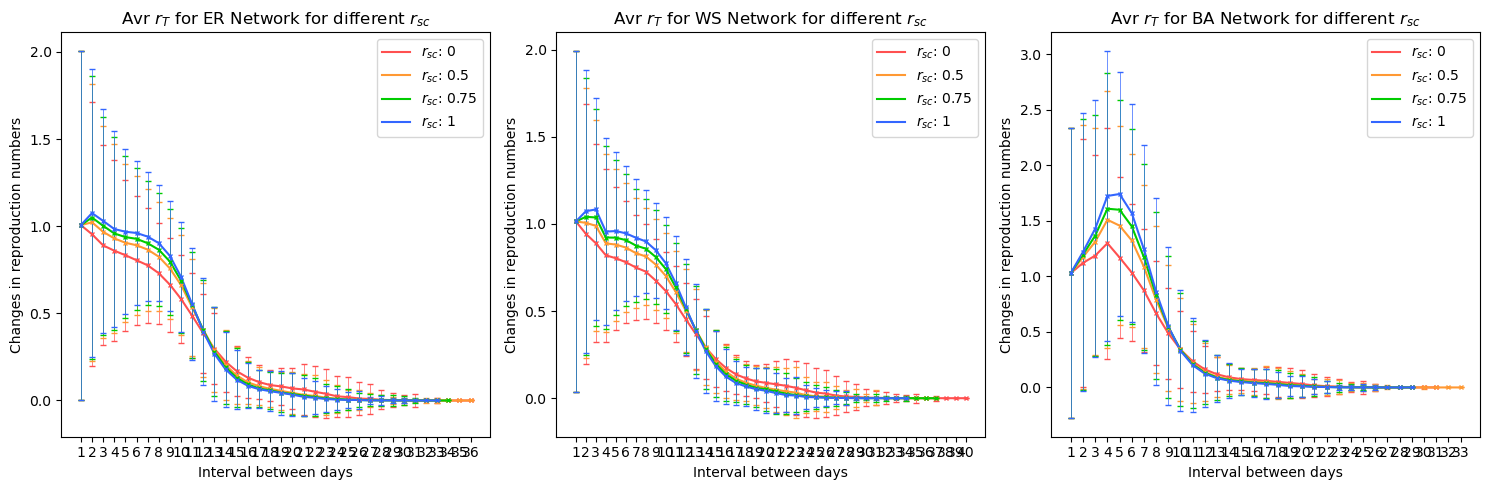

In [20]:
# 2a. Plot only r_T for each network and compare between networks
fig, axs = plt.subplots(1, 3, figsize = (15,5))
plot_colors = ['#ff5050', '#ff9933', '#00cc00', '#3366ff'] 
T_end_ER = max(len(ER_2b_data[0][0]), len(ER_2b_data[1][0]), len(ER_2b_data[2][0]), len(ER_2b_data[3][0]))
T_end_WS = max(len(WS_2b_data[0][0]), len(WS_2b_data[1][0]), len(WS_2b_data[2][0]), len(WS_2b_data[3][0]))
T_end_BA = max(len(BA_2b_data[0][0]), len(BA_2b_data[1][0]), len(BA_2b_data[2][0]), len(BA_2b_data[3][0]))

for k in range(4):
    plot_label = "$r_{sc}$: "+ str(r_triangle_set[k]) 
    ######### For ER Network #########
    axs[0].plot(ER_2b_data[k][0], ER_2b_data[k][3], label  = plot_label, color = plot_colors[k])
    axs[0].errorbar(ER_2b_data[k][0], ER_2b_data[k][3], yerr = ER_2b_data[k][6],\
                   fmt = 'x', markersize = 3, elinewidth = 0.5, capsize = 2, color = plot_colors[k]) 
    
    axs[0].set_xticks(np.arange(1, T_end_ER + 1, 1))
    
    ER_title_label= "Avr $r_T$ for ER Network for different $r_{sc}$"   
    axs[0].set_title(ER_title_label)
    axs[0].set_xlabel("Interval between days")
    axs[0].set_ylabel("Changes in reproduction numbers")
    axs[0].legend(loc = 1)
    
    ######### For WS Network #########
    axs[1].plot(WS_2b_data[k][0], WS_2b_data[k][3], label  = plot_label, color = plot_colors[k])
    axs[1].errorbar(WS_2b_data[k][0], WS_2b_data[k][3], yerr = WS_2b_data[k][6],\
                   fmt = 'x', markersize = 3, elinewidth = 0.5, capsize = 2, color = plot_colors[k])   
    axs[1].set_xticks(np.arange(1, T_end_WS + 1, 1))
    
    WS_title_label= "Avr $r_T$ for WS Network for different $r_{sc}$"   
    axs[1].set_title(WS_title_label)
    axs[1].set_xlabel("Interval between days")
    axs[1].set_ylabel("Changes in reproduction numbers")
    axs[1].legend(loc = 1)
    
    ######### For BA Network #########
    axs[2].plot(BA_2b_data[k][0], BA_2b_data[k][3], label  = plot_label, color = plot_colors[k])
    axs[2].errorbar(BA_2b_data[k][0], BA_2b_data[k][3], yerr = BA_2b_data[k][6],\
                   fmt = 'x', markersize = 3, elinewidth = 0.5, capsize = 2, color = plot_colors[k])   
    axs[2].set_xticks(np.arange(1, T_end_BA + 1, 1))
    
    BA_title_label= "Avr $r_T$ for BA Network for different $r_{sc}$"   
    axs[2].set_title(BA_title_label)
    axs[2].set_xlabel("Interval between days")
    axs[2].set_ylabel("Changes in reproduction numbers")
    axs[2].legend(loc = 1)
    
plt.tight_layout()
plt.show()

#### <u> 4.5.2.1 Results and Discussions </u>
(1) For $r_l$ = 1 case, without SC, expect close to $r_U$. With SC, it is more evident that $r_T$ tends towards $r_O$ (see Annex B). Aka with inclusion of SC, there are more obvious changes to the $r_T$<br>

(2) We also see that SC is quite prevalent in the starting few stages. Not surprising because each node is at least involved in one 2-simplex across each network. SC is also shortlived as seen where at some point in time, all reproduction numbers w SC fall below the one without (suggesting not much SC interactions anymore). <br>

(3) We see that w/out SC, ER and WS, $r_T$ gives a decreasing trend throughout. But w SC, theres a slight increment at the initial few stages before declining (except for at WS w $r_{sc}$ = 0.5) in general. This is interesting as our investigation of WS and ER network so far (even for Chapter 3) has not shown such a trend. This suggests that w SC, theres a possibility of an initial spike like the BA network too!<br>

(4) We see that in general, the inclusion of $r_{sc}$ does shorten the epidemic duration which make sense, since $r_{sc}$ adds on more reproducibility, helping to end the epidemic sooner. 



#### <u> 4.5.3 Effects of $r_{sc}$ for different $D_{recover}$</u>
Now we test the effect of SC when the epidemic has different $D_{recover}$. We shall use $r_l$ = 1 since it gives the most change as seen in 4.5.2. 

In [21]:
# np.random.seed(43434)
# number_of_simulations = 5000
# N_simulation_seeds = np.random.choice(1000000, number_of_simulations, replace = False)

# #Smallest r_l (set as 0.5 as a default)
# I0 = 1
# r_l = 3
# D_recover_array = np.array([1, 3, 5])

In [22]:
#FOR D = 1
location_3c = r"C:\Users\lione\Desktop\Y4S2\PH4421 FYP\Data for simplicial complex\Part (3) Comparing D = 1, 3, 5 for SC = 0.5, 0.75, 1 for rl = 1 and 2 [Show SC only comes in at later part]\For rl = 1\D = 1, rl = 1, test diff r_tri"
ER_3c_data = [] #index 0: no simplex, 1: 0.5, and so on
WS_3c_data = []
BA_3c_data = []

file_names_ER_3c = ["\ER_avr_simplex_D1_rl1_r_tri_none", "\ER_avr_simplex_D1_rl1_r_tri_0.5", \
                "\ER_avr_simplex_D1_rl1_r_tri_0.75", "\ER_avr_simplex_D1_rl1_r_tri_1"]

file_names_WS_3c = ["\WS_avr_simplex_D1_rl1_r_tri_none", "\WS_avr_simplex_D1_rl1_r_tri_0.5", \
                "\WS_avr_simplex_D1_rl1_r_tri_0.75", "\WS_avr_simplex_D1_rl1_r_tri_1"]

file_names_BA_3c = ["\BA_avr_simplex_D1_rl1_r_tri_none", "\BA_avr_simplex_D1_rl1_r_tri_0.5", \
                "\BA_avr_simplex_D1_rl1_r_tri_0.75", "\BA_avr_simplex_D1_rl1_r_tri_1"]

for j in range(4):
    ER_3c_data.append(csv_file_opener(location_3c, file_names_ER_3c[j]))
    WS_3c_data.append(csv_file_opener(location_3c, file_names_WS_3c[j]))
    BA_3c_data.append(csv_file_opener(location_3c, file_names_BA_3c[j]))
    
#FOR D = 5
location_3d = r"C:\Users\lione\Desktop\Y4S2\PH4421 FYP\Data for simplicial complex\Part (3) Comparing D = 1, 3, 5 for SC = 0.5, 0.75, 1 for rl = 1 and 2 [Show SC only comes in at later part]\For rl = 1\D = 5, rl = 1, test diff r_tri"
ER_3d_data = [] #index 0: no simplex, 1: 0.5, and so on
WS_3d_data = []
BA_3d_data = []

file_names_ER_3d = ["\ER_avr_simplex_D5_rl1_r_tri_none", "\ER_avr_simplex_D5_rl1_r_tri_0.5", \
                "\ER_avr_simplex_D5_rl1_r_tri_0.75", "\ER_avr_simplex_D5_rl1_r_tri_1"]

file_names_WS_3d = ["\WS_avr_simplex_D5_rl1_r_tri_none", "\WS_avr_simplex_D5_rl1_r_tri_0.5", \
                "\WS_avr_simplex_D5_rl1_r_tri_0.75", "\WS_avr_simplex_D5_rl1_r_tri_1"]

file_names_BA_3d = ["\BA_avr_simplex_D5_rl1_r_tri_none", "\BA_avr_simplex_D5_rl1_r_tri_0.5", \
                "\BA_avr_simplex_D5_rl1_r_tri_0.75", "\BA_avr_simplex_D5_rl1_r_tri_1"]

for j in range(4):
    ER_3d_data.append(csv_file_opener(location_3d, file_names_ER_3d[j]))
    WS_3d_data.append(csv_file_opener(location_3d, file_names_WS_3d[j]))
    BA_3d_data.append(csv_file_opener(location_3d, file_names_BA_3d[j]))  

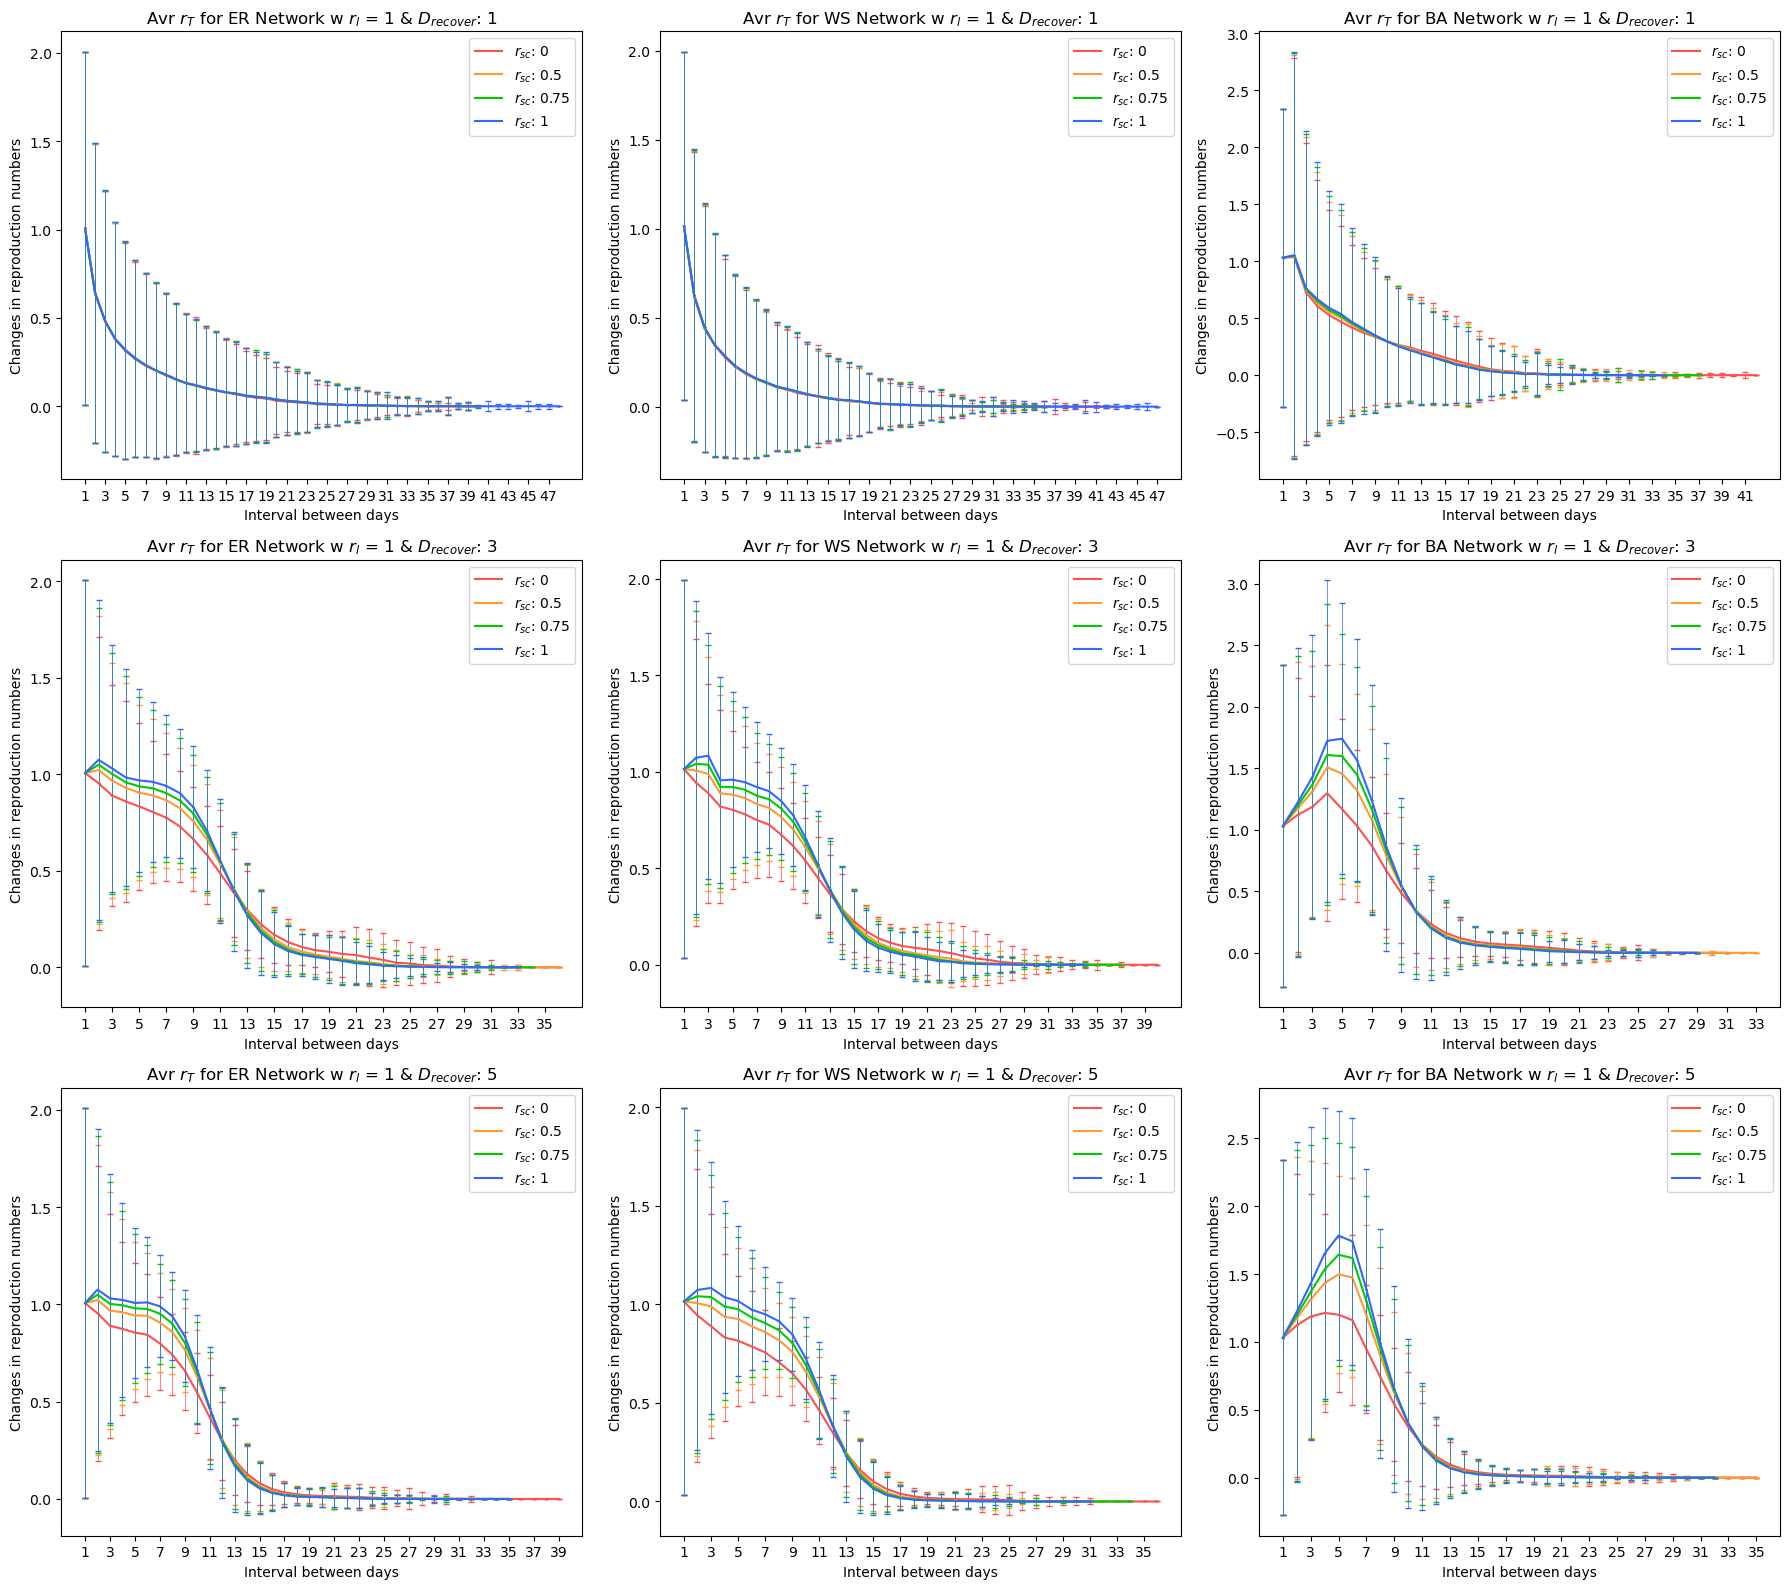

In [23]:
plot_colors = ['#ff5050', '#ff9933', '#00cc00', '#3366ff']
ER_data_diff_D = np.array([ER_3c_data, ER_2b_data, ER_3d_data])
T_max_ER_D1 = len(max(list(np.transpose(ER_data_diff_D[0])[0]), key = len))
T_max_ER_D3 = len(max(list(np.transpose(ER_data_diff_D[1])[0]), key = len))
T_max_ER_D5 = len(max(list(np.transpose(ER_data_diff_D[2])[0]), key = len))
ER_time_diff_D = [T_max_ER_D1, T_max_ER_D3, T_max_ER_D5]

WS_data_diff_D = np.array([WS_3c_data, WS_2b_data, WS_3d_data])
T_max_WS_D1 = len(max(list(np.transpose(WS_data_diff_D[0])[0]), key = len))
T_max_WS_D3 = len(max(list(np.transpose(WS_data_diff_D[1])[0]), key = len))
T_max_WS_D5 = len(max(list(np.transpose(WS_data_diff_D[2])[0]), key = len))
WS_time_diff_D = [T_max_WS_D1, T_max_WS_D3, T_max_WS_D5]

BA_data_diff_D = np.array([BA_3c_data, BA_2b_data, BA_3d_data])
T_max_BA_D1 = len(max(list(np.transpose(BA_data_diff_D[0])[0]), key = len))
T_max_BA_D3 = len(max(list(np.transpose(BA_data_diff_D[1])[0]), key = len))
T_max_BA_D5 = len(max(list(np.transpose(BA_data_diff_D[2])[0]), key = len))
BA_time_diff_D = [T_max_BA_D1, T_max_BA_D3, T_max_BA_D5]


fig, axs = plt.subplots(3, 3, figsize = (18,16)) #color = '#993300'
D_recovery_set = [1, 3, 5]

#### For ER network
for q in range (len(D_recovery_set)):
    for k in range(4):
        plot_label = "$r_{sc}$: " + str(r_triangle_set[k])
        ############### FOR ER NETWORK ########################
        axs[q][0].plot(ER_data_diff_D[q][k][0],ER_data_diff_D[q][k][3] , label = plot_label, color = plot_colors[k])
        axs[q][0].errorbar(ER_data_diff_D[q][k][0], ER_data_diff_D[q][k][3], yerr = ER_data_diff_D[q][k][6],\
                           fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = plot_colors[k])

        ER_title_label= "Avr $r_T$ for ER Network w $r_l$ = 1 & $D_{recover}$: " + str(D_recovery_set[q])   

        axs[q][0].set_xticks(np.arange(1, ER_time_diff_D[q] + 1, 2))
        axs[q][0].set_title(ER_title_label)
        axs[q][0].set_xlabel("Interval between days")
        axs[q][0].set_ylabel("Changes in reproduction numbers")
        axs[q][0].legend(loc = 1)
        
        ############### FOR WS NETWORK ########################
        
        axs[q][1].plot(WS_data_diff_D[q][k][0],WS_data_diff_D[q][k][3] , label = plot_label, color = plot_colors[k])
        axs[q][1].errorbar(WS_data_diff_D[q][k][0], WS_data_diff_D[q][k][3], yerr = WS_data_diff_D[q][k][6],\
                           fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = plot_colors[k])

        WS_title_label= "Avr $r_T$ for WS Network w $r_l$ = 1 & $D_{recover}$: " + str(D_recovery_set[q])   

        axs[q][1].set_xticks(np.arange(1, WS_time_diff_D[q] + 1, 2))
        axs[q][1].set_title(WS_title_label)
        axs[q][1].set_xlabel("Interval between days")
        axs[q][1].set_ylabel("Changes in reproduction numbers")
        axs[q][1].legend(loc = 1)
        
        ############### FOR BA NETWORK ########################
        
        axs[q][2].plot(BA_data_diff_D[q][k][0], BA_data_diff_D[q][k][3] , label = plot_label, color = plot_colors[k])
        axs[q][2].errorbar(BA_data_diff_D[q][k][0], BA_data_diff_D[q][k][3], yerr = BA_data_diff_D[q][k][6],\
                           fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = plot_colors[k])

        BA_title_label= "Avr $r_T$ for BA Network w $r_l$ = 1 & $D_{recover}$: " + str(D_recovery_set[q])   

        axs[q][2].set_xticks(np.arange(1, BA_time_diff_D[q] + 1, 2))
        axs[q][2].set_title(BA_title_label)
        axs[q][2].set_xlabel("Interval between days")
        axs[q][2].set_ylabel("Changes in reproduction numbers")
        axs[q][2].legend(loc = 1)

plt.tight_layout()
plt.show()

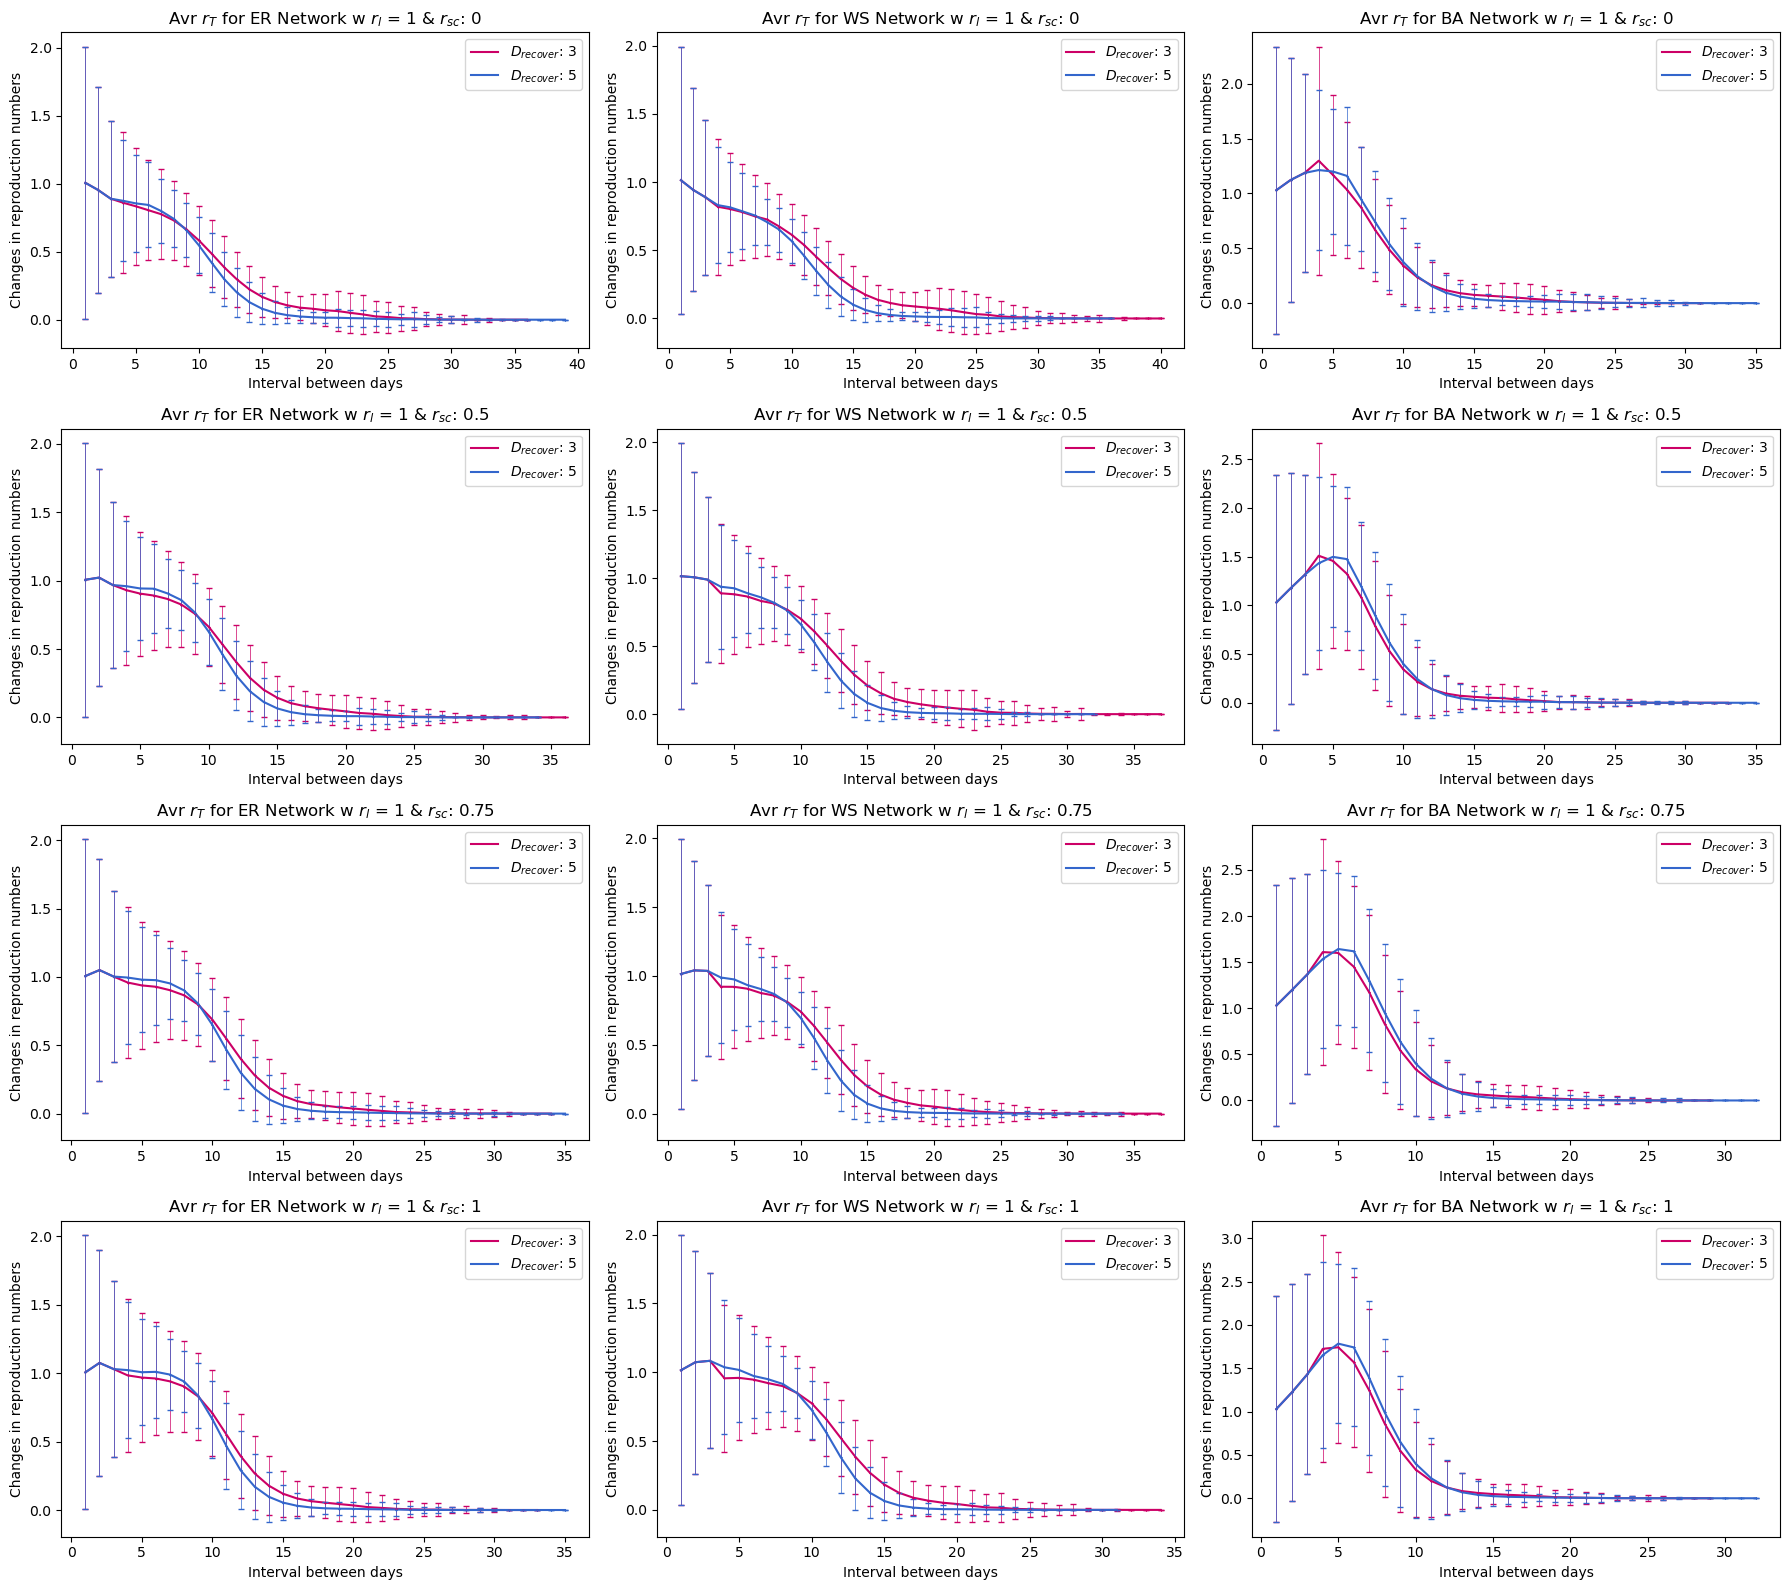

In [24]:
### THESE PLOTS WILL TELL ME THAT SC HAS NO IMPACT EVEN IF D INCREASE
fig, axs = plt.subplots(4, 3, figsize = (18,16)) #color = '#993300'
D_recovery_set = [1, 3, 5]
color_contrast = ['#cc0066', '#3366cc']

for b in range (2):
    for q in range(4):
        ############### FOR ER NETWORK ########################
        plot_label = '$D_{recover}$: ' + str(D_recovery_set[b+1])
        axs[q][0].plot(ER_data_diff_D[b+1][q][0],ER_data_diff_D[b+1][q][3] , label = plot_label, color = color_contrast[b])
        axs[q][0].errorbar(ER_data_diff_D[b+1][q][0], ER_data_diff_D[b+1][q][3], yerr = ER_data_diff_D[b+1][q][6],\
                           fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = color_contrast[b])
  
        ER_title_label = "Avr $r_T$ for ER Network w $r_l$ = 1 & $r_{sc}$: " + str(r_triangle_set[q])
        axs[q][0].set_title(ER_title_label)
        axs[q][0].set_xlabel("Interval between days")
        axs[q][0].set_ylabel("Changes in reproduction numbers")
        axs[q][0].legend(loc = 1)

        ############### FOR WS NETWORK ########################
        plot_label = '$D_{recover}$: ' + str(D_recovery_set[b+1])
        axs[q][1].plot(WS_data_diff_D[b+1][q][0],WS_data_diff_D[b+1][q][3] , label = plot_label, color = color_contrast[b])
        axs[q][1].errorbar(WS_data_diff_D[b+1][q][0], WS_data_diff_D[b+1][q][3], yerr = WS_data_diff_D[b+1][q][6],\
                           fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = color_contrast[b])
  
        WS_title_label = "Avr $r_T$ for WS Network w $r_l$ = 1 & $r_{sc}$: " + str(r_triangle_set[q])
        axs[q][1].set_title(WS_title_label)
        axs[q][1].set_xlabel("Interval between days")
        axs[q][1].set_ylabel("Changes in reproduction numbers")
        axs[q][1].legend(loc = 1)
        
        ############### FOR BA NETWORK ########################
        plot_label = '$D_{recover}$: ' + str(D_recovery_set[b+1])
        axs[q][2].plot(BA_data_diff_D[b+1][q][0],BA_data_diff_D[b+1][q][3] , label = plot_label, color = color_contrast[b])
        axs[q][2].errorbar(BA_data_diff_D[b+1][q][0], BA_data_diff_D[b+1][q][3], yerr = BA_data_diff_D[b+1][q][6],\
                           fmt = 'x', markersize = 1, elinewidth = 0.5, capsize = 2, color = color_contrast[b])
  
        BA_title_label = "Avr $r_T$ for BA Network w $r_l$ = 1 & $r_{sc}$: " + str(r_triangle_set[q])
        axs[q][2].set_title(BA_title_label)
        axs[q][2].set_xlabel("Interval between days")
        axs[q][2].set_ylabel("Changes in reproduction numbers")
        axs[q][2].legend(loc = 1)
        
    
plt.tight_layout()
plt.show()

#### <u> 4.5.3.1 Results & Discussion </u>
(1) We see that for D = 1, SC has no effect on the $r_T$ for both ER and WS network and very minimal effect on BA network. The first highly suggests that recovery is so fast that SC has no time to come into play. The latter could be that in the same day pairwise coin tosses did not transmit but group did. But the occurence of that is small and thus changes is very mild. 

(2) By comparing the $r_T$ for $D_{recover}$ = 3 & 5 across each $r_{sc}$, we see very minimal effect $r_{sc}$ has on $r_T$ across all networks as it is being increased. W/out SC, we see the r_T trend for D_recover  = 5 is always higher than that of D_recover = 3 for both the ER and WS network up to t = 9, before r_T gets smaller. On the other hand, we have the trend of r_T for D = 3 higher than D = 5 for BA network, up to t = 5, before it gets larger. With increasing SC, we see the same trend and the difference in increment in r_T is very small. Therefore, we conclude that $r_{sc}$ does not have much effect on $r_T$ for different D recover. 

#### <u> 5. Summary of Simplicial Complex </u>